## ColliderML: Data exploration notebook (CLI download → Polars load)

This notebook demonstrates how to:

- Download ColliderML Parquet shards to local disk using the `colliderml` CLI
- Load local Parquet shards with Polars via `colliderml.core.load_tables`
- Produce basic multiplicity + kinematics plots
- Demonstrate pileup subsampling (reduce to a target vertex count)
- Optionally visualize a single event (tracker hits + calo cells)

### Prereqs

- Install the package in your environment (ideally `collider-env`):
  - `pip install -e ".[dev]"`
- Make sure you have downloaded the data you want (see below).



### Download (one shard per config)

Run this in a shell **once** (downloads Parquet shards into your local cache):

- Dataset: `CERN/ColliderML-Release-1`
- Configs:
  - `ttbar_pu0_particles`
  - `ttbar_pu0_tracker_hits`
  - `ttbar_pu0_calo_hits`
  - `ttbar_pu0_tracks`

Example:

- `colliderml download --channels ttbar --pileup pu0 --max-events 200`

Notes:

- `--max-events` decides how many shards to download to ensure the maximum number of events is met; the loader below enforces exact selection.
- To control the cache location:
  - Set `$COLLIDERML_DATA_DIR`, or pass `--out /path/to/cache`.




In [27]:
from __future__ import annotations

import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from colliderml.core import load_tables, collect_tables
from colliderml.physics import subsample_pileup, assign_primary_ancestor, CALO_DETECTOR_CODES
from colliderml.physics.calibration import apply_calo_calibration, odd_default_calo_calibration
from colliderml.polars import explode_particles, explode_tracker_hits, explode_calo_cells_and_contribs
from colliderml.viz import eta_from_xyz, eta_from_pxpypz, r_from_xy, plot_binned_sums_with_xerr

# Optional plotting
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(12)
pl.Config.set_tbl_cols(20)



polars.config.Config

In [28]:
cfg = {
    "dataset_id": "CERN/ColliderML-Release-1",
    "channels": "ttbar",
    "pileup": "pu0",
    "objects": ["particles", "tracker_hits", "calo_hits", "tracks"],
    "split": "train",
    "lazy": True,
    "max_events": 200,
    # "data_dir": "/custom/cache",  # optional override
}

tables = load_tables(cfg)
# Materialize for interactive exploration/plotting
frames = collect_tables(tables)

# What did we load?
print("tables:", list(frames.keys()))
print("shapes:", {k: v.shape for k, v in frames.items()})

# Event-table reminder: each row is one event; most columns are lists.
for name in ["particles", "tracker_hits", "calo_hits", "tracks"]:
    if name in frames:
        t = frames[name]
        list_cols = [c for c, dt in t.schema.items() if isinstance(dt, pl.List)]
        print(f"{name}: list columns (first 8) = {list_cols[:8]}")


tables: ['particles', 'tracker_hits', 'calo_hits', 'tracks']
shapes: {'particles': (200, 18), 'tracker_hits': (200, 13), 'calo_hits': (200, 9), 'tracks': (200, 9)}
particles: list columns (first 8) = ['particle_id', 'pdg_id', 'mass', 'energy', 'charge', 'vx', 'vy', 'vz']
tracker_hits: list columns (first 8) = ['x', 'y', 'z', 'true_x', 'true_y', 'true_z', 'time', 'particle_id']
calo_hits: list columns (first 8) = ['detector', 'total_energy', 'x', 'y', 'z', 'contrib_particle_ids', 'contrib_energies', 'contrib_times']
tracks: list columns (first 8) = ['d0', 'z0', 'phi', 'theta', 'qop', 'majority_particle_id', 'hit_ids', 'track_id']


In [50]:
# --- Event-table view (Polars): one row per event, list columns per object ---

particles_evt = frames["particles"]
tracker_evt = frames["tracker_hits"]
calo_evt = frames["calo_hits"]

# Per-event multiplicities (counts are list lengths)
particles_mult = particles_evt.select(
    pl.col("event_id"),
    pl.col("particle_id").list.len().alias("n_particles"),
    pl.col("vertex_primary").list.max().alias("n_vertices"),
)

tracker_mult = tracker_evt.select(
    pl.col("event_id"),
    pl.col("x").list.len().alias("n_tracker_hits"),
)

calo_mult = calo_evt.select(
    pl.col("event_id"),
    pl.col("detector").list.len().alias("n_calo_cells"),
)

mult = particles_mult.join(tracker_mult, on="event_id").join(calo_mult, on="event_id")
mult.head()


event_id,n_particles,n_vertices,n_tracker_hits,n_calo_cells
u32,u32,u16,u32,u32
0,1846,1,1636,9472
1,2719,1,2504,16636
2,3047,1,3180,19814
3,3951,1,3664,21088
4,2096,1,3203,12553


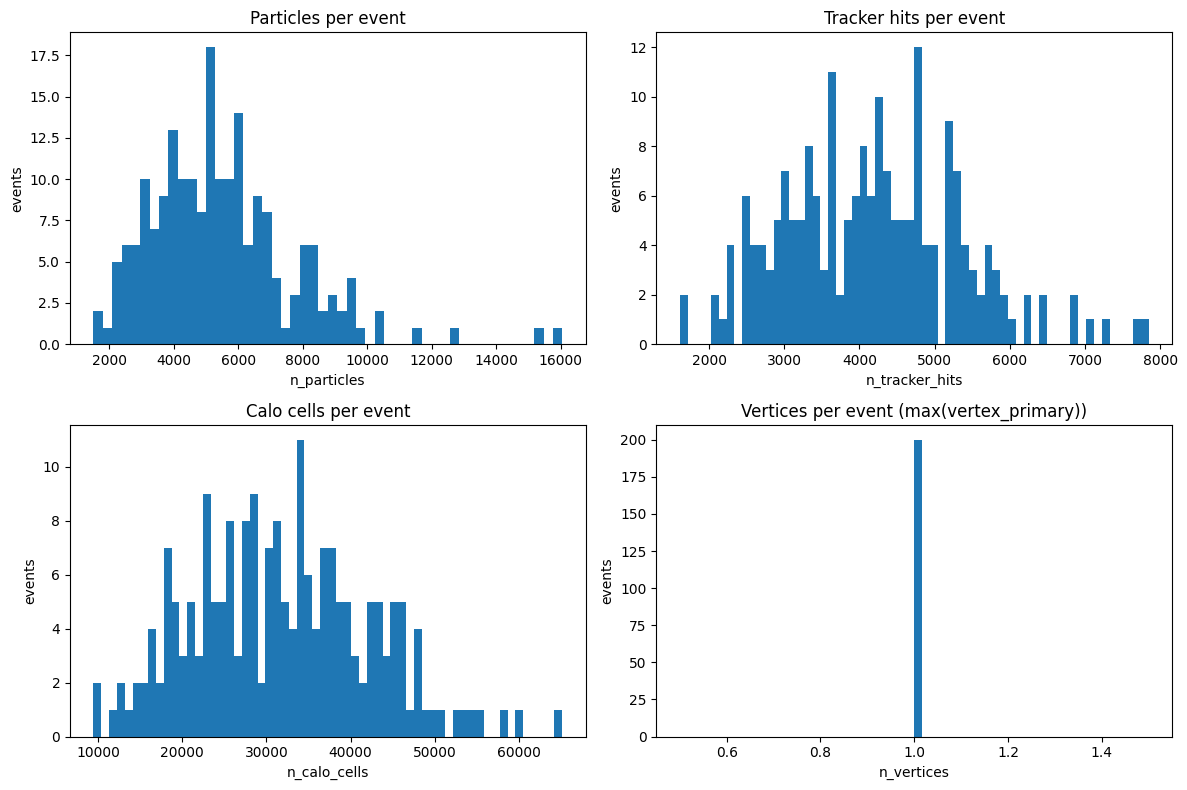

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

ax[0].hist(mult["n_particles"].to_list(), bins=50)
ax[0].set_title("Particles per event")
ax[0].set_xlabel("n_particles")
ax[0].set_ylabel("events")

ax[1].hist(mult["n_tracker_hits"].to_list(), bins=60)
ax[1].set_title("Tracker hits per event")
ax[1].set_xlabel("n_tracker_hits")
ax[1].set_ylabel("events")

ax[2].hist(mult["n_calo_cells"].to_list(), bins=60)
ax[2].set_title("Calo cells per event")
ax[2].set_xlabel("n_calo_cells")
ax[2].set_ylabel("events")

ax[3].hist(mult["n_vertices"].to_list(), bins=60)
ax[3].set_title("Vertices per event (max(vertex_primary))")
ax[3].set_xlabel("n_vertices")
ax[3].set_ylabel("events")

plt.tight_layout()
plt.show()


In [52]:
particles_flat

,event_id,particle_id,pdg_id,mass,energy,charge,vx,vy,vz,time,...,py,pz,perigee_d0,perigee_z0,vertex_primary,parent_id,primary,particle_index,pt,p
0,0,76,213,0.738762,2491.611816,1.0,0.009162,-0.003694,196.070236,0.442453,...,-0.117263,2491.611816,NaN,NaN,1,9,True,0,0.121895,2491.611819
1,0,77,-211,0.139570,489.566223,-1.0,0.009162,-0.003694,196.070236,0.442453,...,0.317618,489.565979,NaN,NaN,1,9,True,1,0.467221,489.566202
2,0,78,211,0.139570,199.210312,1.0,0.009162,-0.003694,196.070236,0.442453,...,-0.172773,199.210144,NaN,NaN,1,9,True,2,0.206841,199.210251
3,0,79,113,0.701754,140.076035,0.0,0.009162,-0.003694,196.070236,0.442453,...,0.453400,140.073120,0.000000,0.000000,1,9,True,3,0.569244,140.074277
4,0,80,111,0.134980,50.874249,0.0,0.009162,-0.003694,196.070236,0.442453,...,-0.564865,50.870861,0.009607,195.865234,1,9,True,4,0.571123,50.874067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,0,2029,11,0.000511,0.125133,-1.0,381.877167,1436.042969,2357.318115,9.191267,...,0.068330,0.103774,NaN,NaN,1,2021,False,1841,0.069920,0.125132
1842,0,2030,11,0.000511,0.001657,-1.0,295.532288,934.017212,3023.778809,12.168322,...,-0.000479,0.001409,-488.299591,4712.993652,1,2020,False,1842,0.000708,0.001577
1843,0,2031,11,0.000511,0.000702,-1.0,451.400635,802.024780,3025.309326,13.758835,...,0.000350,-0.000197,124.341476,3434.682617,1,2020,False,1843,0.000439,0.000482
1844,0,2032,11,0.000511,0.001125,-1.0,246.831131,958.045105,1920.449707,7.282954,...,-0.000838,0.000475,NaN,NaN,1,2019,False,1844,0.000883,0.001003


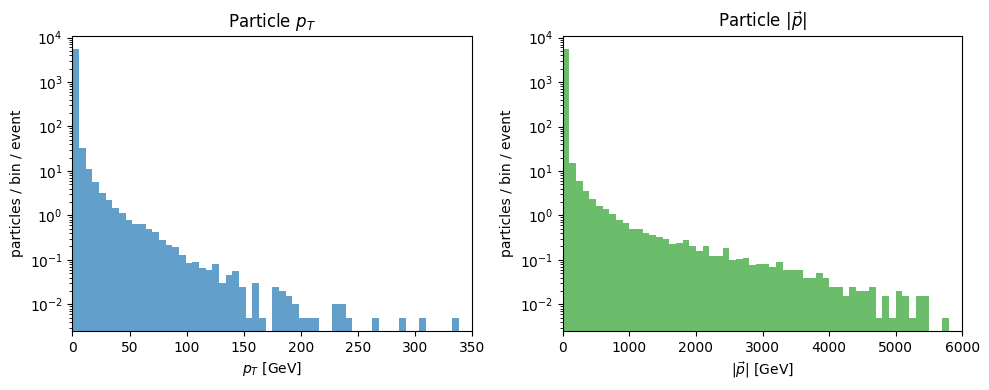

In [55]:
# Particle-level kinematics (explode event-table) -> pandas DataFrame
particles_flat = explode_particles(particles_evt)

# Compute kinematic columns (numpy)
# NOTE: older pandas may not support Series.to_numpy(dtype=...), so cast explicitly.
px = particles_flat["px"].to_numpy().astype(float)
py = particles_flat["py"].to_numpy().astype(float)
pz = particles_flat["pz"].to_numpy().astype(float)

particles_flat["pt"] = np.sqrt(px**2 + py**2)
particles_flat["p"] = np.sqrt(px**2 + py**2 + pz**2)

# To avoid log(0), filter out zero or negative values
pt_vals = particles_flat.loc[particles_flat["pt"] > 0, "pt"].to_numpy()
p_vals = particles_flat.loc[particles_flat["p"] > 0, "p"].to_numpy()

# Normalize to "objects per bin per event"
# (total counts per bin) / (n_events)
num_events = int(particles_evt.height)
pt_w = np.ones_like(pt_vals, dtype=float) / max(num_events, 1)
p_w = np.ones_like(p_vals, dtype=float) / max(num_events, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(pt_vals, bins=60, range=(0, 350), weights=pt_w, color="tab:blue", alpha=0.7)
ax[0].set_title("Particle $p_T$")
ax[0].set_xlabel(r"$p_T$ [GeV]")
ax[0].set_ylabel("particles / bin / event")
ax[0].set_yscale("log")
ax[0].set_xlim(0, 350)

ax[1].hist(p_vals, bins=60, range=(0, 6000), weights=p_w, color="tab:green", alpha=0.7)
ax[1].set_title("Particle $|\\vec{p}|$")
ax[1].set_xlabel(r"$|\vec{p}|$ [GeV]")
ax[1].set_ylabel("particles / bin / event")
ax[1].set_yscale("log")
ax[1].set_xlim(0, 6000)

plt.tight_layout()
plt.show()


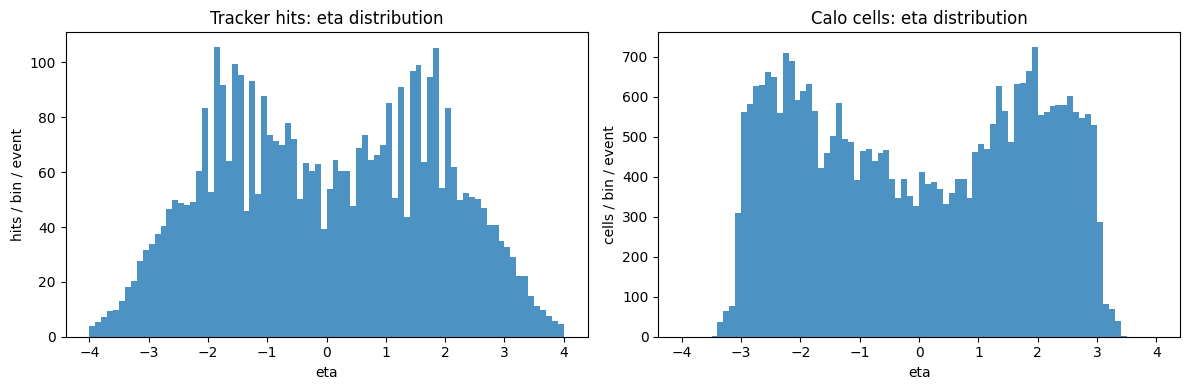

In [56]:
# Exploded view (pandas): eta distributions for tracker hits and calo cells

hits_flat_all = explode_tracker_hits(frames["tracker_hits"])  # pandas
cells_all, _contribs_all = explode_calo_cells_and_contribs(frames["calo_hits"])  # pandas

eta_hits = eta_from_xyz(
    hits_flat_all["x"].to_numpy().astype(float),
    hits_flat_all["y"].to_numpy().astype(float),
    hits_flat_all["z"].to_numpy().astype(float),
)
eta_cells = eta_from_xyz(
    cells_all["x"].to_numpy().astype(float),
    cells_all["y"].to_numpy().astype(float),
    cells_all["z"].to_numpy().astype(float),
)

# Normalize to "objects per bin per event"
num_events = int(frames["particles"].height)
h_w = np.ones_like(eta_hits, dtype=float) / max(num_events, 1)
c_w = np.ones_like(eta_cells, dtype=float) / max(num_events, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(eta_hits, bins=80, range=(-4, 4), weights=h_w, alpha=0.8)
ax[0].set_title("Tracker hits: eta distribution")
ax[0].set_xlabel("eta")
ax[0].set_ylabel("hits / bin / event")

ax[1].hist(eta_cells, bins=80, range=(-4, 4), weights=c_w, alpha=0.8)
ax[1].set_title("Calo cells: eta distribution")
ax[1].set_xlabel("eta")
ax[1].set_ylabel("cells / bin / event")

plt.tight_layout()
plt.show()


In [57]:
# Event-level labeling + flattened hit tables for visualization
# - Tracker: one point per hit
# - Calo: one point per contribution (cell position repeated per contrib)
#
# We will plot in (r, eta) where r = sqrt(x^2 + y^2) and eta is computed from (r,z).

plot_space = "r_eta"

event_id = int(frames["particles"]["event_id"][0])

# --- Particles: compute primary ancestor labels and build a lookup table ---
particles_evt = frames["particles"].filter(pl.col("event_id") == event_id)
particles_evt_labeled = assign_primary_ancestor(particles_evt)
particles_flat_labeled = explode_particles(particles_evt_labeled)  # pandas

pid_to_anc = (
    particles_flat_labeled[["particle_id", "primary_ancestor_id"]]
    .drop_duplicates(subset=["particle_id"], keep="first")
    .copy()
)
# Ensure integer join keys
pid_to_anc["particle_id"] = pid_to_anc["particle_id"].astype("int64")

# --- Tracker hits: explode and attach primary ancestor ---
tracker_evt = frames["tracker_hits"].filter(pl.col("event_id") == event_id)
hits_flat = explode_tracker_hits(tracker_evt) if tracker_evt.height else None
if hits_flat is not None and len(hits_flat) > 0:
    hits_flat = hits_flat.copy()
    hits_flat["particle_id"] = hits_flat["particle_id"].astype("int64")
    hits_flat = hits_flat.merge(pid_to_anc, on="particle_id", how="left")

# --- Calo contributions: explode cells + contributions, attach position + primary ancestor ---
calo_evt = frames["calo_hits"].filter(pl.col("event_id") == event_id)
if calo_evt.height:
    cells, contribs = explode_calo_cells_and_contribs(calo_evt)  # pandas
    # Attach position (x,y,z) from cell table to each contribution
    pos_cols = [c for c in ["x", "y", "z"] if c in cells.columns]
    contribs = contribs.merge(
        cells[["event_id", "cell_index"] + pos_cols],
        on=["event_id", "cell_index"],
        how="left",
    )
    contribs["particle_id"] = contribs["particle_id"].astype("int64")
    contribs = contribs.merge(pid_to_anc, on="particle_id", how="left")
else:
    cells, contribs = None, None

pid_to_anc.head()


,particle_id,primary_ancestor_id
0,76,76
1,77,77
2,78,78
3,79,79
4,80,80


In [58]:
# Decay traversal demo: follow parent links and assign a root ancestor id per particle
particles_labeled = assign_primary_ancestor(frames["particles"])

# Show one event-table row: list columns contain per-particle arrays
particles_labeled.select("event_id", "particle_id", "parent_id", "primary_ancestor_id").head(1)


event_id,particle_id,parent_id,primary_ancestor_id
u32,list[u64],list[i64],list[i64]
0,"[76, 77, … 2033]","[9, 9, … 2019]","[76, 77, … 321]"


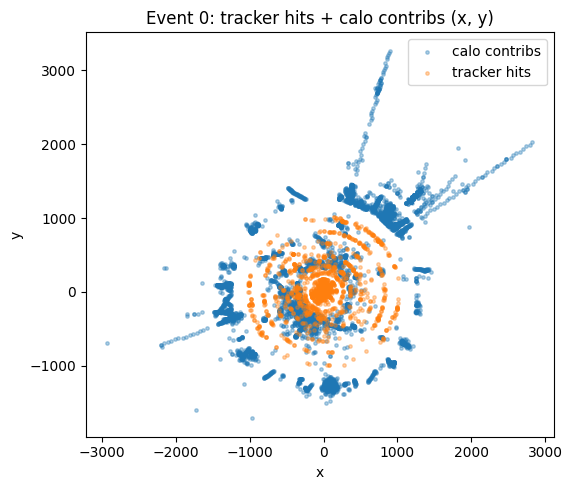

In [59]:
# Lightweight event display (student demo): tracker hits + calo contributions in (x, y)

if hits_flat is None or contribs is None or len(hits_flat) == 0 or len(contribs) == 0:
    print("No hits/contribs to display for this event")
else:
    # Tracker hits
    xh = hits_flat["x"].to_numpy().astype(float)
    yh = hits_flat["y"].to_numpy().astype(float)

    # Calo contribs (positions are cell positions)
    xc = contribs["x"].to_numpy().astype(float)
    yc = contribs["y"].to_numpy().astype(float)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.scatter(xc, yc, s=6, alpha=0.35, label="calo contribs")
    ax.scatter(xh, yh, s=6, alpha=0.35, label="tracker hits")
    ax.set_title(f"Event {event_id}: tracker hits + calo contribs (x, y)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc="best")
    plt.tight_layout()
    ax.set_aspect("equal")
    plt.show()


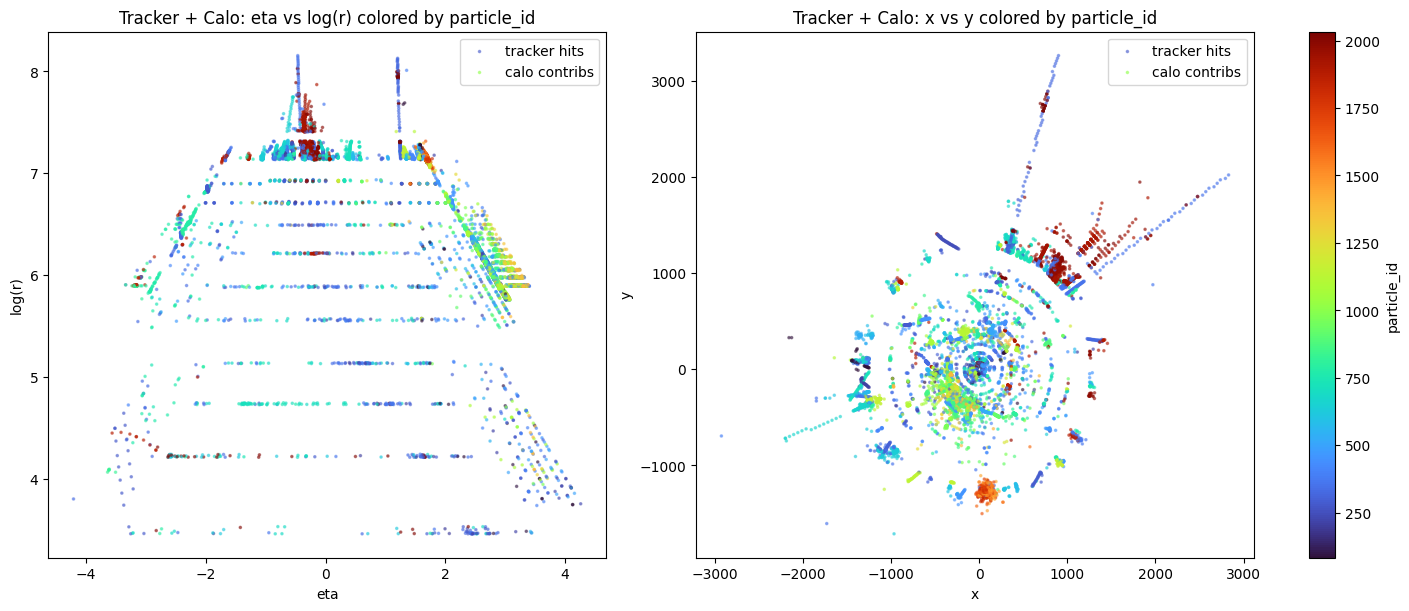

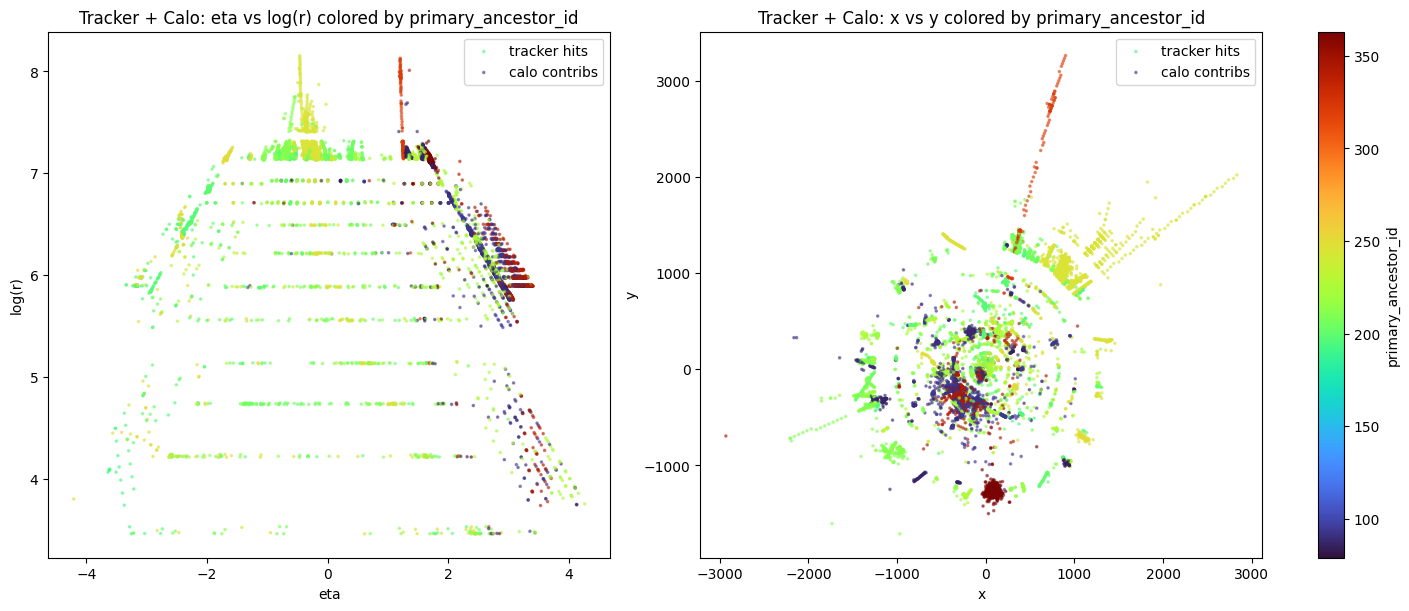

In [60]:
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def _r_eta_from_xyz(x_list, y_list, z_list, eps: float = 1e-12):
    r_list = []
    eta_list = []
    for x, y, z in zip(x_list, y_list, z_list):
        x = float(x)
        y = float(y)
        z = float(z)
        r = math.sqrt(x * x + y * y)
        R = math.sqrt(r * r + z * z)
        # eta from polar angle: eta = 0.5 * ln((R+z)/(R-z))
        eta = 0.5 * math.log((R + z + eps) / (R - z + eps))
        r_list.append(r)
        eta_list.append(eta)
    return r_list, eta_list

def _get_xy_reta(df):
    # Returns x, y, eta, r as Python lists
    x = df["x"].to_list() if hasattr(df["x"], "to_list") else df["x"].tolist()
    y = df["y"].to_list() if hasattr(df["y"], "to_list") else df["y"].tolist()
    z = df["z"].to_list() if hasattr(df["z"], "to_list") else df["z"].tolist()
    r, eta = _r_eta_from_xyz(x, y, z)
    return x, y, eta, r

def _plot_eta_logr_and_xy_by(column: str, titles: tuple[str, str]):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    ax_1, ax_2 = axes

    # Prepare the data
    eta_all, logr_all, c_all = [], [], []
    x_all, y_all = [], []

    # Helper to process each (flat) DataFrame and collect data
    def process_df(_df):
        if _df is not None and len(_df) > 0:
            x, y, eta, r = _get_xy_reta(_df)
            # Use log(r), handle r == 0
            logr = [math.log(rr) if rr > 0 else float("-inf") for rr in r]
            if column in _df.columns:
                c = _df[column].fillna(-1).to_list() if hasattr(_df[column], "to_list") else _df[column].fillna(-1).tolist()
            else:
                c = [-1] * len(x)
            return eta, logr, c, x, y
        return [], [], [], [], []

    # Collect all data for common normalization for coloring
    for _df in (hits_flat, contribs):
        eta, logr, c, x, y = process_df(_df)
        eta_all += eta
        logr_all += logr
        c_all += c
        x_all += x
        y_all += y

    if not eta_all:
        ax_1.set_title("No tracker/calo points available")
        ax_2.set_title("No tracker/calo points available")
        plt.show()
        return

    norm = Normalize(vmin=min(c_all), vmax=max(c_all))
    cmap = "turbo"

    # Plot tracker hits and calo contribs on both axes
    marker_settings = [
        (hits_flat, ".", 10, 0.5, "tracker hits"),
        (contribs, ".", 10, 0.5, "calo contribs")
    ]
    for _df, marker, size, alpha, label in marker_settings:
        eta, logr, c, x, y = process_df(_df)
        if len(eta) == 0:
            continue
        # subplot 1: eta vs log(r)
        ax_1.scatter(eta, logr, c=c, s=size, alpha=alpha, cmap=cmap, norm=norm, marker=marker, label=label)
        # subplot 2: x vs y
        ax_2.scatter(x, y, c=c, s=size, alpha=alpha, cmap=cmap, norm=norm, marker=marker, label=label)

    # Format subplot 1: eta vs log(r)
    ax_1.set_title(titles[0])
    ax_1.set_xlabel("eta")
    ax_1.set_ylabel("log(r)")
    ax_1.legend(loc="best")

    # Format subplot 2: x vs y
    ax_2.set_title(titles[1])
    ax_2.set_xlabel("x")
    ax_2.set_ylabel("y")
    ax_2.legend(loc="best")

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, fraction=0.046, pad=0.04, label=column)

    plt.show()

_plot_eta_logr_and_xy_by(
    "particle_id",
    (
        "Tracker + Calo: eta vs log(r) colored by particle_id",
        "Tracker + Calo: x vs y colored by particle_id",
    )
)

_plot_eta_logr_and_xy_by(
    "primary_ancestor_id",
    (
        "Tracker + Calo: eta vs log(r) colored by primary_ancestor_id",
        "Tracker + Calo: x vs y colored by primary_ancestor_id",
    )
)



In [61]:
# Single-event energy vs eta (student demo)
# Goal: compare
# - calorimeter deposited energy (calibrated), split ECAL vs HCAL
# - truth energy of *root* particles (no parent in stored graph)

# Choose one event (first in the shard)
event_id = int(frames["particles"]["event_id"][0])

# --- Calo contributions for this event (pandas) ---
calo_evt = frames["calo_hits"].filter(pl.col("event_id") == event_id)
if not calo_evt.height:
    raise RuntimeError(f"No calo hits for event_id={event_id}")

calo_evt_cal = apply_calo_calibration(calo_evt, odd_default_calo_calibration(apply_to_contrib=True))

cells, contribs = explode_calo_cells_and_contribs(calo_evt_cal)  # pandas
pos_cols = [c for c in ["x", "y", "z", "detector"] if c in cells.columns]
contribs = contribs.merge(cells[["event_id", "cell_index"] + pos_cols], on=["event_id", "cell_index"], how="left")

# --- Particles for this event (pandas) ---
particles_evt = frames["particles"].filter(pl.col("event_id") == event_id)
particles_flat = explode_particles(particles_evt)

print("event_id:", event_id)
print("n calo contrib rows:", len(contribs))
print("n particles:", len(particles_flat))


event_id: 0
n calo contrib rows: 16437
n particles: 1846


In [62]:
# Sanity-check a few columns we will use for plotting
contribs[["event_id", "cell_index", "detector", "particle_id", "energy"]].head(10)


,event_id,cell_index,detector,particle_id,energy
0,0,0,14,1009,0.016745
1,0,0,14,1010,0.004798
2,0,0,14,994,0.021651
3,0,0,14,1047,0.025501
4,0,0,14,1046,0.023625
5,0,1,11,917,0.018425
6,0,1,11,915,0.005818
7,0,2,14,1360,0.082236
8,0,3,11,1117,0.021030
9,0,4,12,769,0.209418


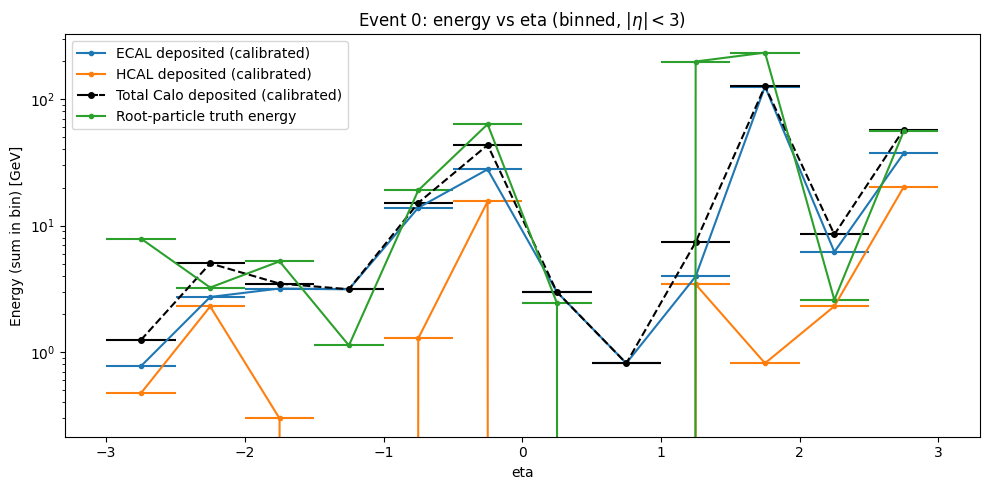

In [65]:
# Compute eta for calo contributions (from cell position) and particles (from momentum)

# Calo contribution eta (cell position)
eta_calo = eta_from_xyz(
    contribs["x"].to_numpy().astype(float),
    contribs["y"].to_numpy().astype(float),
    contribs["z"].to_numpy().astype(float),
)
energy_dep = contribs["energy"].to_numpy().astype(float)
det = contribs["detector"].to_numpy().astype(int)

# Split by ECAL/HCAL using enum ids
_ecal_ids = {
    CALO_DETECTOR_CODES["ecal_neg_endcap"],
    CALO_DETECTOR_CODES["ecal_barrel"],
    CALO_DETECTOR_CODES["ecal_pos_endcap"],
}
_hcal_ids = {
    CALO_DETECTOR_CODES["hcal_neg_endcap"],
    CALO_DETECTOR_CODES["hcal_barrel"],
    CALO_DETECTOR_CODES["hcal_pos_endcap"],
}

mask_ecal = np.isin(det, list(_ecal_ids))
mask_hcal = np.isin(det, list(_hcal_ids))

# Particle eta + root-particle mask (roots = no parent in stored graph)
eta_part = eta_from_pxpypz(
    particles_flat["px"].to_numpy().astype(float),
    particles_flat["py"].to_numpy().astype(float),
    particles_flat["pz"].to_numpy().astype(float),
)
truth_energy = particles_flat["energy"].to_numpy().astype(float)

parent = pd.to_numeric(particles_flat["parent_id"], errors="coerce")
pid = pd.to_numeric(particles_flat["particle_id"], errors="coerce")
pid_set = set(pid.dropna().astype("int64").tolist())
mask_root = parent.isna() | (parent == -1) | (~parent.isin(pid_set))
mask_root = mask_root.to_numpy(dtype=bool)

# Limit to |eta|<3 for the plot
eta_mask_calo = np.abs(eta_calo) < 3
eta_mask_part = np.abs(eta_part) < 3

# Bin edges: Δη = 0.5 from -3 to 3
eta_bins = np.linspace(-3.0, 3.0, 13)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_binned_sums_with_xerr(
    ax,
    eta_calo[mask_ecal & eta_mask_calo],
    energy_dep[mask_ecal & eta_mask_calo],
    bins=eta_bins,
    label="ECAL deposited (calibrated)",
    fmt="o-",
    lw=1.5,
    ms=3,
    capsize=0,
)
plot_binned_sums_with_xerr(
    ax,
    eta_calo[mask_hcal & eta_mask_calo],
    energy_dep[mask_hcal & eta_mask_calo],
    bins=eta_bins,
    label="HCAL deposited (calibrated)",
    fmt="o-",
    lw=1.5,
    ms=3,
    capsize=0,
)
# Add total calorimeter (ECAL + HCAL) deposited energy curve
mask_total_calo = (mask_ecal | mask_hcal) & eta_mask_calo
plot_binned_sums_with_xerr(
    ax,
    eta_calo[mask_total_calo],
    energy_dep[mask_total_calo],
    bins=eta_bins,
    label="Total Calo deposited (calibrated)",
    fmt="o--",
    lw=1.5,
    ms=4,
    capsize=0,
    color="k"
)

plot_binned_sums_with_xerr(
    ax,
    eta_part[mask_root & eta_mask_part],
    truth_energy[mask_root & eta_mask_part],
    bins=eta_bins,
    label="Root-particle truth energy",
    fmt="o-",
    lw=1.5,
    ms=3,
    capsize=0,
)

ax.set_title(f"Event {event_id}: energy vs eta (binned, $|\\eta| < 3$)")
ax.set_xlabel("eta")
ax.set_ylabel("Energy (sum in bin) [GeV]")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()
